# Experimentación 

In [1]:
from main import * 
from exp_runner import * 
from exp_utils import *
import requests
import pycountry_convert as pc
import pandas as pd
import os 
import dill
from time import perf_counter

## Conseguimos las IP's

In [2]:
urls = {
    'ARGENTINA': "exactas.uba.ar",
    'BOLIVIA': "www.uatf.edu.bo",
    'PERU': "www.unmsm.edu.pe",
    'BRASIL': "www5.usp.br",
    'CANADA': "www.uvic.ca",
    'UK': "129.67.242.155",
    'SUIZA': "ethz.ch",
    'RUSIA': "www.msu.ru",
    'ISRAEL': "www.technion.ac.il",
    'CHINA': "www.tsinghua.edu.cn",
    'AUSTRALIA': "130.56.66.152",
}

In [3]:
def get_info(url):
    url = 'http://ip-api.com/json/' + url
    info = requests.get(url=url, params={}).json()
    try:
        continent_code = pc.country_alpha2_to_continent_code(info['countryCode'])
        info.update({'continentCode': continent_code})
    except KeyError:
        info['countryCode'] = None
        info['continentCode'] = None
    return info 
ips = [get_info(url)['query'] for _, url in urls.items()]

### Puertos especiales

In [4]:
ports=[2525,3306,2082,2083,2086,2087,2095,2096,2077,2078]
resps = []
for ip in ips:
    print("\n Running for {} \n".format(ip))
    sn_config = {'ip': ip, 'ports': ports, 'timeout': 3, 'retries': 1, 'validate_before': True}
    runner = ExpRunner(sn_config, jobname='frosende_bokita', prefer_loading_saved_data=True, save_data=True)
    resps.append(runner.run_exp(verbose=False))


 Running for 157.92.32.18 

Running validation...
Validating TCP has an HTTP/HTTPS answer port
Validated. Final timeout: 0.19
Scanning TCP ports . . .
Scanning UDP ports . . .
Finished retry 0

 Running for www.uatf.edu.bo 

Running validation...
Validating TCP has an HTTP/HTTPS answer port
Validated. Final timeout: 0.21
Scanning TCP ports . . .
Scanning UDP ports . . .
Finished retry 0

 Running for 200.62.146.14 

Running validation...
Validating TCP has an HTTP/HTTPS answer port
Validated. Final timeout: 0.75
Scanning TCP ports . . .
Scanning UDP ports . . .
Finished retry 0

 Running for 200.144.248.54 

Running validation...
Validating TCP has an HTTP/HTTPS answer port
Validated. Final timeout: 0.6
Scanning TCP ports . . .
Scanning UDP ports . . .
Finished retry 0

 Running for 142.104.197.120 

Running validation...
Validating TCP has an HTTP/HTTPS answer port
Validated. Final timeout: 0.6
Scanning TCP ports . . .
Scanning UDP ports . . .
Finished retry 0

 Running for 129.67.24

### IP's

In [6]:
ports = list(range(0,1026))
resps = []
for ip in ips:
    print("\n Running for {} \n".format(ip))
    sn_config = {'ip': ip, 'ports': ports, 'timeout': 3, 'retries': 1, 'validate_before': True}
    runner = ExpRunner(sn_config, jobname='frosende', prefer_loading_saved_data=True, save_data=True)
    resps.append(runner.run_exp(verbose=False))


 Running for 157.92.32.18 


 Running for 181.115.147.162 


 Running for 200.62.146.14 


 Running for 200.144.248.54 


 Running for 142.104.197.120 


 Running for 129.67.242.155 


 Running for 129.132.19.216 


 Running for 188.44.50.103 


 Running for 132.68.239.58 


 Running for 166.111.4.100 


 Running for 130.56.66.152 



## Cargo todas las respuestas

In [7]:
federesps = load_data('frosende')
danteresps = load_data('dolmedo')
roniresps = load_data('rbarylko')
charlyresps = load_data('cgiudice')

In [8]:
globalresp = [federesps, danteresps, roniresps, charlyresps]
ips = ['181.115.147.162', '200.62.146.14', '188.44.50.103', '130.56.66.152']
for data in globalresp:
    for i in range(len(data)-1, -1, -1):
        if not data[i].ip in ips:
            data.pop(i)
            i = i+1

In [9]:
ports_by_response_tcp = [get_ports_by_response(r,'TCP',['130.56.66.152']) for r in globalresp]

## Puertos abiertos

In [11]:
index_open = set()
for port_d in ports_by_response_tcp:
    for status, port_l in port_d.items():
        if status == 'open':
            index_open = index_open.union(set(port_l))
            
print("TCP ports opened: {}".format(list(index_open)))

TCP ports opened: [80, 53, 21, 22, 443]


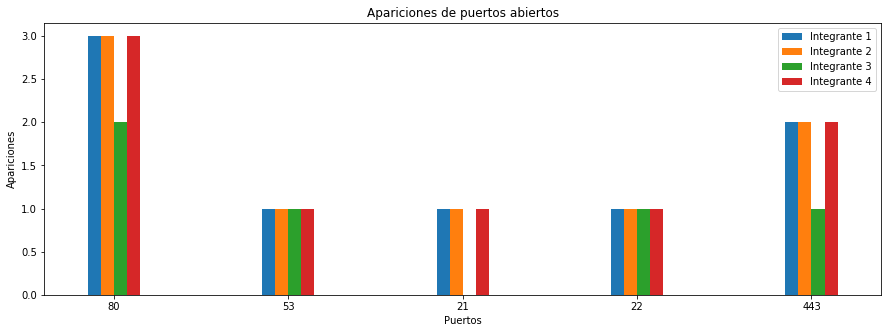

In [12]:
d = {'Integrante 1': [], 'Integrante 2': [], 'Integrante 3': [], 'Integrante 4': []}
for i in range(len(ports_by_response_tcp)):
    d['Integrante ' + str(i+1)] = [ports_by_response_tcp[i]['open'].count(p) for p in index_open]
df = pd.DataFrame(d,index=index_open)
ax = df.plot(kind='bar', width=0.3, rot=0, figsize=(15,5))
ax.set_title('Apariciones de puertos abiertos')
ax.set_ylabel('Apariciones')
ax.set_xlabel('Puertos')

plt.show()

## Puertos cerrados y filtrados

In [13]:
closed_and_filtered = [resp.copy() for resp in ports_by_response_tcp]
for d in closed_and_filtered:
    d.pop('open')

In [14]:
c_and_f_d = {'Cantidad de respuestas': [0, 0]}
for res in closed_and_filtered:
    c_and_f_d['Cantidad de respuestas'][0] =  c_and_f_d['Cantidad de respuestas'][0] + len(res['closed'])
    c_and_f_d['Cantidad de respuestas'][1] =  c_and_f_d['Cantidad de respuestas'][1] + len(res['filtered'])
c_and_f_d 

{'Cantidad de respuestas': [2161, 9096]}

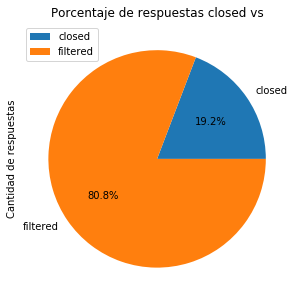

In [15]:
df = pd.DataFrame(c_and_f_d, index=['closed', 'filtered'])
ax = df.plot.pie(y='Cantidad de respuestas', figsize=(5, 5), autopct='%1.1f%%')
ax.set_title('Porcentaje de respuestas closed vs')

plt.show()

### Plot raw data del dataframe monolítico

In [2]:
sdl = superdataframemonolitico()
sdl = sdl.replace('dolmedo', 'Red 1')
sdl = sdl.replace('rbarylko', 'Red 2')
sdl = sdl.replace('cgiudice', 'Red 3')
sdl = sdl.replace('frosende', 'Red 4')

In [3]:
import seaborn as sns
sns.set(style="darkgrid")

## Análisis TCP

### Para todas las ips

In [19]:
by_ip = sdl[sdl['ip'] != '130.56.66.152']
by_prot_and_status = by_ip.groupby(['protocol', 'status'])

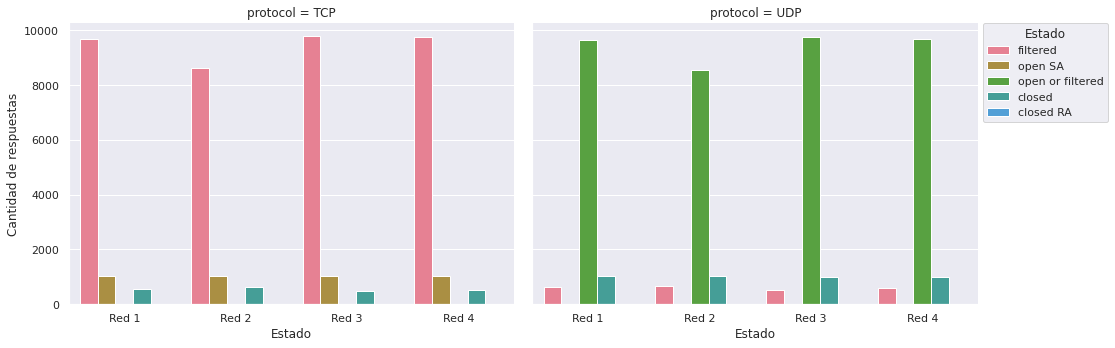

In [4]:
sns.set_palette("husl")
#df = sdl[sdl['ip'] != '130.56.66.152']
g = sns.catplot(x='jobname', hue='status', col='protocol', data=sdl, kind='count', legend=False)
g.set_ylabels("Cantidad de respuestas")
g.set_xlabels("Estado")
plt.legend(title='Estado', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
fig = plt.gcf()
fig.set_size_inches(14, 5)

In [70]:
sns.set_palette("husl")
#df = sdl[sdl['ip'] != '130.56.66.152']
g = sns.catplot(x='status', hue='jobname', col='protocol', data=sdl, kind='count', legend=False)
g.set_ylabels("Cantidad de respuestas")
g.set_xlabels("Estado")
g.despine(left=True)
plt.legend(title='Red',bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
fig = plt.gcf()
fig.set_size_inches(14, 5)

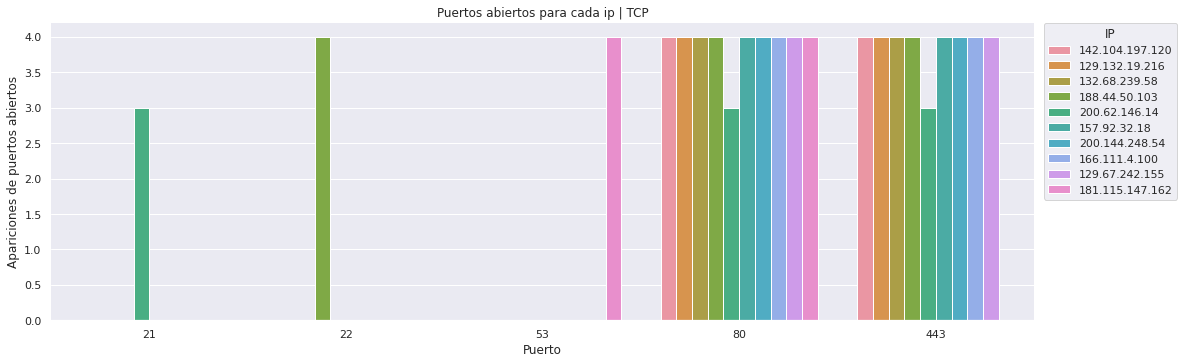

In [21]:
sns.set_palette("husl")
df = sdl[sdl['ip'] != '130.56.66.152']
df = df.groupby('status').get_group('open SA')
g = sns.catplot(x='port', hue='ip', data=df, kind='count', legend=False)
g.set_ylabels("Apariciones de puertos abiertos")
g.set_xlabels("Puerto")
g.despine(left=True)
plt.legend(title='IP', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.title('Puertos abiertos para cada ip | TCP')
fig = plt.gcf()
fig.set_size_inches(16, 5)

In [10]:
df = sdl.groupby('protocol').get_group('UDP')
df['status'].unique()

array(['open or filtered', 'closed', 'filtered'], dtype=object)

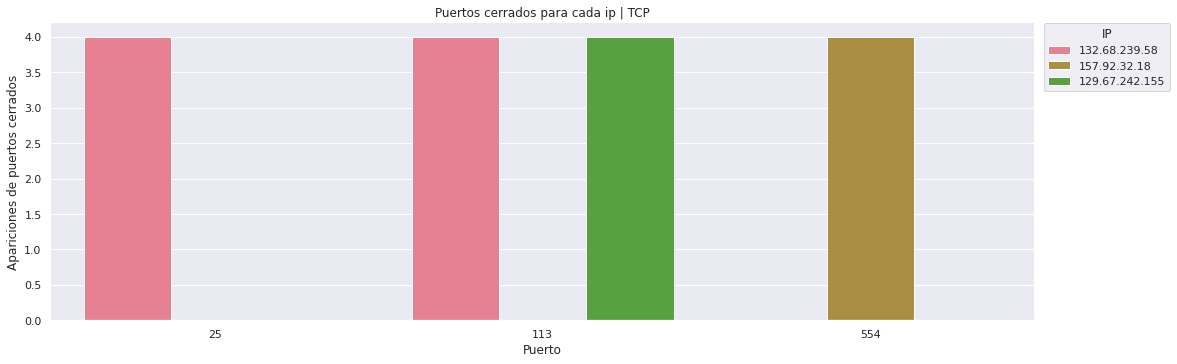

In [34]:
sns.set_palette("husl")
df = sdl[sdl['protocol'] == 'TCP']
df = df.groupby('status').get_group('closed RA')
g = sns.catplot(x='port', hue='ip', data=df, kind='count', legend=False)
g.set_ylabels("Apariciones de puertos cerrados")
g.set_xlabels("Puerto")
g.despine(left=True)
plt.legend(title='IP', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.title('Puertos cerrados para cada ip | TCP')
fig = plt.gcf()
fig.set_size_inches(16, 5)

In [39]:
sns.set_palette("husl")
df = sdl[sdl['protocol'] == 'UDP']
df = df[df['ip'] != '129.132.19.216']
df['status'].unique()

array(['open or filtered', 'filtered'], dtype=object)

In [31]:
ips = {country:get_info(url)['query'] for country, url in urls.items()}
ips

{'ARGENTINA': '157.92.32.18',
 'BOLIVIA': '181.115.147.162',
 'PERU': '200.62.146.14',
 'BRASIL': '200.144.248.54',
 'CANADA': '142.104.197.120',
 'UK': '129.67.242.155',
 'SUIZA': '129.132.19.216',
 'RUSIA': '188.44.50.103',
 'ISRAEL': '132.68.239.58',
 'CHINA': '166.111.4.100',
 'AUSTRALIA': '130.56.66.152'}

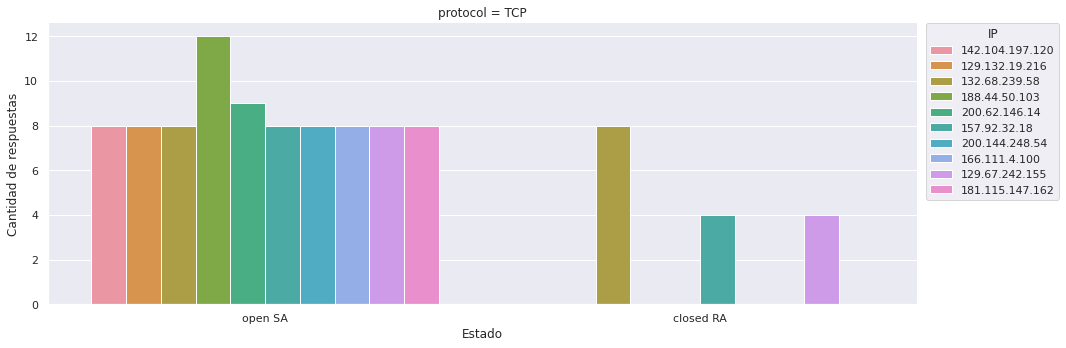

In [56]:
df = sdl[sdl['ip'] != '130.56.66.152']
df = df[df['status'] != 'filtered']
df = df[df['status'] != 'closed']
df = df[df['status'] != 'open or filtered']
#df = df.groupby('protocol').get_group('TCP')
g = sns.catplot(x='status', hue='ip', col='protocol', data=df, kind='count', legend=False)
g.set_ylabels("Cantidad de respuestas")
g.set_xlabels("Estado")
plt.legend(title='IP', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
#plt.title('Cantidad de respuestas para los estados open SA y closed RA')
fig = plt.gcf()
fig.set_size_inches(14, 5)

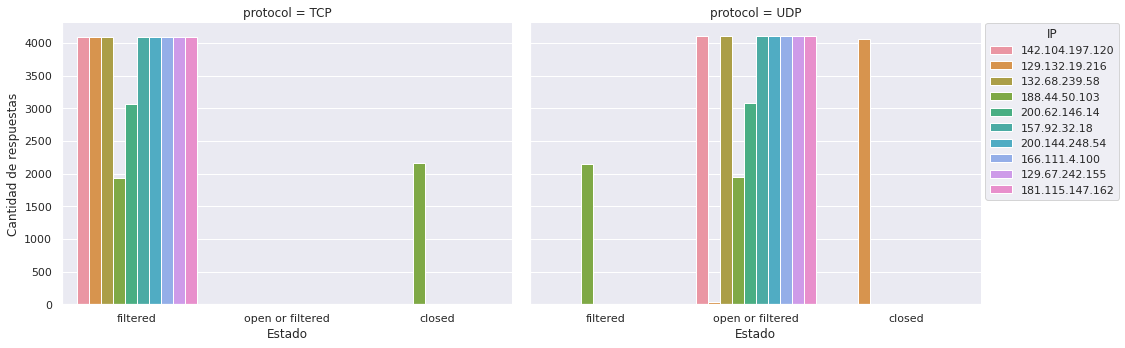

In [58]:
df = sdl[sdl['ip'] != '130.56.66.152']
df = df[df['status'] != 'open SA']
df = df[df['status'] != 'open']
df = df[df['status'] != 'closed RA']
#df = df.groupby('protocol').get_group('TCP')
g = sns.catplot(x='status', hue='ip', col='protocol', data=df, kind='count', legend=False)
g.set_ylabels("Cantidad de respuestas")
g.set_xlabels("Estado")
plt.legend(title='IP', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
#plt.title('Cantidad de respuestas para los estados filtered y closed')
fig = plt.gcf()
fig.set_size_inches(14, 5)

### Para algunas ips

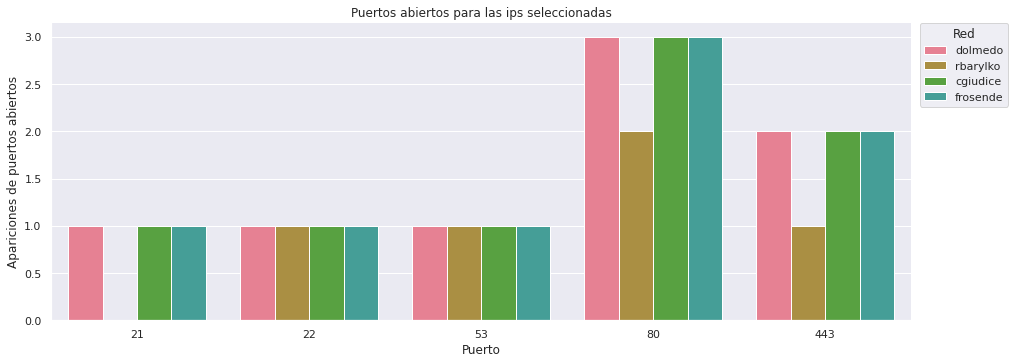

In [60]:
ips = ['181.115.147.162', '200.62.146.14', '188.44.50.103']
by_protocol_and_status = sdl.groupby(['protocol', 'status'])
tcp_open = by_protocol_and_status.get_group(('TCP', 'open SA'))
df = pd.DataFrame()
for ip, df_ip in tcp_open.groupby('ip'):
    if ip in ips:
        df = pd.concat([df, df_ip], sort=False)
g = sns.catplot(x='port', hue='jobname', data=df, kind='count', legend=False)
g.set_ylabels("Apariciones de puertos abiertos")
g.set_xlabels("Puerto")
plt.title('Puertos abiertos para las ips seleccionadas')
plt.legend(title='Red', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
fig = plt.gcf()
fig.set_size_inches(14, 5)

In [26]:
tcp_all = sdl.groupby('protocol').get_group('TCP')
tcp_closed_and_filt = tcp_all[tcp_all['status'] != 'open SA']

In [27]:
tcp_closed_and_filt['ip'].unique()
df = pd.DataFrame()
for ip in ips:
    df = pd.concat([df, tcp_closed_and_filt[tcp_closed_and_filt['ip'] == ip]])

In [28]:
g = sns.catplot(x='status', hue='jobname', data=df, kind='count')
g.set_ylabels("Cantidad de respuestas")
g.set_xlabels("Estado")
plt.title('Cantidad de respuestas con estado cerrado o filtrado')

plt.show()

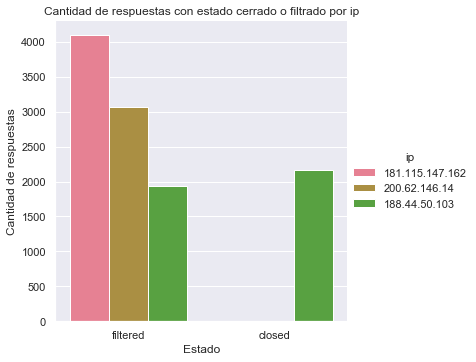

In [29]:
g = sns.catplot(x='status', hue='ip', data=df, kind='count')
g.set_ylabels("Cantidad de respuestas")
g.set_xlabels("Estado")
plt.title('Cantidad de respuestas con estado cerrado o filtrado por ip')

plt.show()